In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as stats

In [3]:
df = pd.read_csv('cookie_cats.csv')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [4]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [7]:
df['userid'].duplicated().any()

False

In [8]:
df = df.drop(labels='userid', axis=1) #удаляем ненужный столбец с индексами

In [9]:
df.groupby(['version']).describe().round(2) #статистика по двум выборкам

sum_gamerounds                                              
                 count   mean     std  min  25%   50%   75%      max
version                                                             
gate_30        44700.0  52.46  256.72  0.0  5.0  17.0  50.0  49854.0
gate_40        45489.0  51.30  103.29  0.0  5.0  16.0  52.0   2640.0

Но некоторые игроки могли вообще не играть, а некоторые, наоборот, сыграть очень много раундов, что повлияет на среднее, поэтому мы не можем быть уверены в показательности данных. Для рассмотрения этого лучше всего подойдут коробчатые диаграммы.

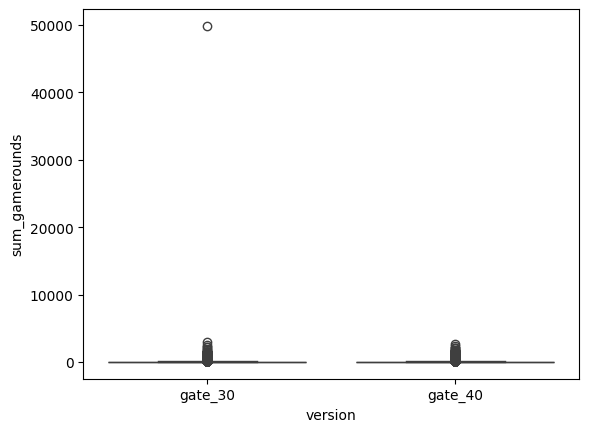

In [10]:
sns.boxplot(x=df.version, y=df.sum_gamerounds)
plt.show()

График выше соответствует сумме всех раундов. Теперь рассмотрим коробочные диаграмме для отдельных retention:

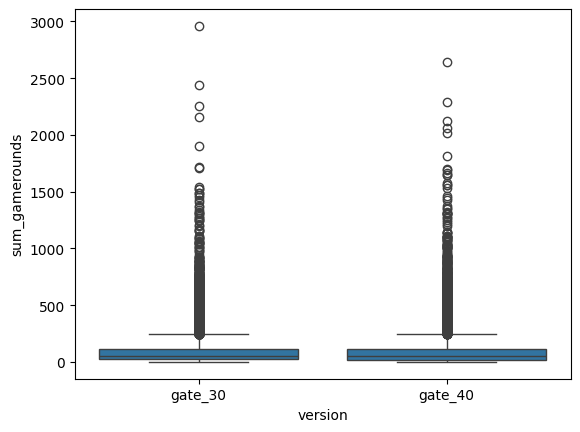

In [11]:
sns.boxplot(data=df[df.retention_1 == True], y='sum_gamerounds', x='version')
plt.show()

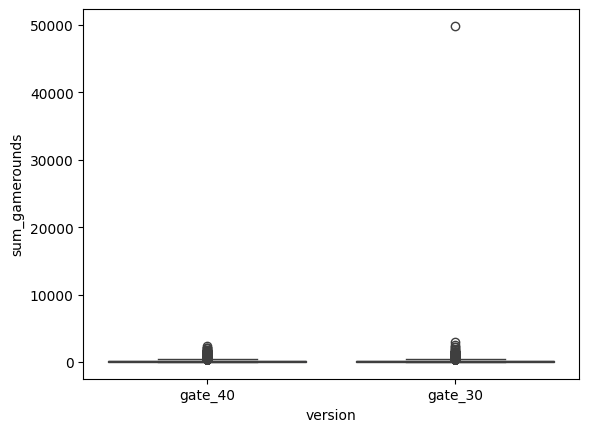

In [12]:
sns.boxplot(data=df[df.retention_7 == True], y='sum_gamerounds', x='version')
plt.show()

На 1 и 3 графике заметен 1 пользователь, который сыграл около 50.000 раундов за неделю после скачивания. Это может существенно влиять на результаты тестирования, поэтому выкинем его

In [13]:
df = df.drop(df.loc[df['sum_gamerounds'] > 40000].index)

Избавимся также и от тех, кто не сыграл не одного раунда, так как они не влияют на наше решение.

In [14]:
df = df.loc[df['sum_gamerounds'] != 0]
df

,version,sum_gamerounds,retention_1,retention_7
0,gate_30,3,False,False
1,gate_30,38,True,False
2,gate_40,165,True,False
3,gate_40,1,False,False
4,gate_40,179,True,True
...,...,...,...,...
90184,gate_40,97,True,False
90185,gate_40,30,False,False
90186,gate_30,28,True,False
90187,gate_40,51,True,False


Теперь еще раз рассмотрим основную информацию по выборкам:

In [16]:
df.groupby(['version']).describe().round(2) #статистика по двум выборкам

sum_gamerounds                                             
                 count   mean     std  min  25%   50%   75%     max
version                                                            
gate_30        42762.0  53.67  103.74  1.0  6.0  18.0  53.0  2961.0
gate_40        43432.0  53.73  105.09  1.0  6.0  18.0  55.0  2640.0

Теперь можно приступать непосредственно к A/B тесту

Нулевая гипотеза: gate_30 == gate_40. Обозначим уровень значимости в стандартные 0.05.


Метрика для тестирование - количество пройденных уровней

Проведем т-тест

In [48]:
control = df[df['version'] == 'gate_30']['sum_gamerounds']
test = df[df['version'] == 'gate_40']['sum_gamerounds']
t_stat, p_value = stats.ttest_ind(control, test)
print(t_stat, p_value)

-0.0851720765870841 0.932124787372842


In [49]:
control = df[df['version'] == 'gate_30']['retention_1']
test = df[df['version'] == 'gate_40']['retention_1']
t_stat, p_value = stats.ttest_ind(control, test)
print(t_stat, p_value)

1.5805933550213924 0.11397471554470703


Уровень значимости больше чем 0.05, значит мы не можем отвергнуть нулевую гипотезу.